<a href="https://colab.research.google.com/github/avionerman/machine_learning_2025/blob/main/competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

#pd.set_option('display.max_columns', 100)

# Data Loading

In [2]:
# load training features and ground truth
train_features = pd.read_csv('train_hh_features.csv')
train_gt = pd.read_csv('train_hh_gt.csv')

# load test features
test_features = pd.read_csv('test_hh_features.csv')

# load poverty rate ground truth
train_rates_gt = pd.read_csv('train_rates_gt.csv')

print(f"Training features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")
print(f"Ground truth shape: {train_gt.shape}")

Training features shape: (104234, 88)
Test features shape: (103023, 88)
Ground truth shape: (104234, 3)


# Merging training features & targets

In [4]:
# having features and targets in diff dfs has no logic at all
train = train_features.merge(train_gt, on=['survey_id', 'hhid'], how='left')

print(f"Merged training shape: {train.shape}")
print(f"\nTarget variable (cons_ppp17) stats:")
print(train['cons_ppp17'].describe())

Merged training shape: (104234, 89)

Target variable (cons_ppp17) stats:
count    104234.000000
mean         11.555229
std          10.034225
min           0.359563
25%           5.439294
50%           8.774002
75%          14.216931
max         236.115680
Name: cons_ppp17, dtype: float64


# Checking missing values

In [8]:
# check total missing values
missing = train.isnull().sum()
missing_pct = (missing / len(train) * 100).round(2)

# check only columns with missing values
missing_df = pd.DataFrame({
    'missing count': missing,
    'missing ratio %': missing_pct
})
missing_df = missing_df[missing_df['missing count'] > 0].sort_values('missing ratio %', ascending=False)

print("total column with missing values:")
print(missing_df)

total column with missing values:
                 missing count  missing ratio %
sector1d                 14129            13.56
dweltyp                   1206             1.16
utl_exp_ppp17               85             0.08
consumed5000                66             0.06
consumed4300                52             0.05
consumed4500                54             0.05
consumed4600                56             0.05
consumed4800                56             0.05
consumed4400                52             0.05
consumed4900                56             0.05
consumed4700                52             0.05
employed                    45             0.04
consumed3900                40             0.04
consumed4000                38             0.04
consumed4100                40             0.04
consumed4200                44             0.04
consumed3800                35             0.03
consumed3700                29             0.03
consumed3300                20             0.02
consum

# SectorID - Unemployment correlation check

In [9]:
print("Employment status when sector1d is missing:")
print(train[train['sector1d'].isnull()]['employed'].value_counts())

print("\nEmployment status when sector1d is NOT missing:")
print(train[train['sector1d'].notna()]['employed'].value_counts())

Employment status when sector1d is missing:
employed
Not employed    14084
Name: count, dtype: int64

Employment status when sector1d is NOT missing:
employed
Employed    90105
Name: count, dtype: int64


Observation:



*   we have 14.084 not eployed household heads with sector1d missing and
*   we have 90.105 employed household heads with the sector1d having a value

Thus, this is not just missing data, it means that is logically missing, since you can't have an employment sector and being unemployed at the same time.


# Handling missing values

In [10]:
# fill sector1d for the unemployed household heads

train['sector1d'] = train['sector1d'].fillna('Not employed')
test_features['sector1d'] = test_features['sector1d'].fillna('Not employed')

print("sector1d missing after fix:")
print(f"  Train: {train['sector1d'].isnull().sum()}")
print(f"  Test: {test_features['sector1d'].isnull().sum()}")

# for the attribute dweltyp (categorical,more than 1% missing) - filling with mode
train['dweltyp'] = train['dweltyp'].fillna(train['dweltyp'].mode()[0])
test_features['dweltyp'] = test_features['dweltyp'].fillna(test_features['dweltyp'].mode()[0])

# for the attribute utl_exp_ppp17 (numerical, 0.08% missing) - filling with median
train['utl_exp_ppp17'] = train['utl_exp_ppp17'].fillna(train['utl_exp_ppp17'].median())
test_features['utl_exp_ppp17'] = test_features['utl_exp_ppp17'].fillna(test_features['utl_exp_ppp17'].median())

# for the attributes of employed, share_secondary, educ_max (almost 0%) - filling with mode
for col in ['employed', 'share_secondary', 'educ_max']:
    train[col] = train[col].fillna(train[col].mode()[0])
    test_features[col] = test_features[col].fillna(test_features[col].mode()[0])

# for all the consumed* columns attributes (binary y/n) - filling with mode, most common value
consumed_cols = [col for col in train.columns if col.startswith('consumed')]
for col in consumed_cols:
    train[col] = train[col].fillna(train[col].mode()[0])
    test_features[col] = test_features[col].fillna(test_features[col].mode()[0])

print(f"Total missing values after imputation:")
print(f"  Train: {train.isnull().sum().sum()}")
print(f"  Test: {test_features.isnull().sum().sum()}")

sector1d missing after fix:
  Train: 0
  Test: 0
Total missing values after imputation:
  Train: 0
  Test: 0


# Filter columns by type

In [11]:
# exclude identifiers, 0 value
id_cols = ['hhid', 'com', 'survey_id', 'strata']

# target col
target_col = 'cons_ppp17'

# binary categorical columns (y/n or Access/No access, and other)
binary_cols = ['male', 'owner', 'water', 'toilet', 'sewer', 'elect',
               'employed', 'any_nonagric', 'urban']

# add the consumed-related columns (binary y/n)
consumed_cols = [col for col in train.columns if col.startswith('consumed')]
binary_cols = binary_cols + consumed_cols

# multi-class categorical columns
multiclass_cols = ['water_source', 'sanitation_source', 'dweltyp', 'educ_max', 'sector1d']

# numerical columns
numerical_cols = ['weight', 'utl_exp_ppp17', 'hsize', 'num_children5', 'num_children10',
                  'num_children18', 'age', 'num_adult_female', 'num_adult_male',
                  'num_elderly', 'sworkershh', 'share_secondary', 'sfworkershh']

# region columns (already numerical 0/1)
region_cols = ['region1', 'region2', 'region3', 'region4', 'region5', 'region6', 'region7']

print(f"ID columns: {len(id_cols)}")
print(f"Binary columns: {len(binary_cols)}")
print(f"Multi-class columns: {len(multiclass_cols)}")
print(f"Numerical columns: {len(numerical_cols)}")
print(f"Region columns: {len(region_cols)}")
print(f"Target: {target_col}")

ID columns: 4
Binary columns: 59
Multi-class columns: 5
Numerical columns: 13
Region columns: 7
Target: cons_ppp17


# Encode binary columns

In [12]:
# mapping for binary columns (59 according to the previous check)
binary_mappings = {
    'Yes': 1, 'No': 0,
    'Male': 1, 'Female': 0,
    'Owner': 1, 'Not owner': 0,
    'Access': 1, 'No access': 0,
    'Employed': 1, 'Not employed': 0,
    'Urban': 1, 'Rural': 0
}

# applying that to train
for col in binary_cols:
    train[col] = train[col].map(binary_mappings)

# applying that to test
for col in binary_cols:
    test_features[col] = test_features[col].map(binary_mappings)

# encoding verification
print("Post encoding result (sample):")
print(train[['male', 'owner', 'urban', 'consumed100']].head())

Post encoding result (sample):
   male  owner  urban  consumed100
0     0      1      1            1
1     0      1      1            1
2     1      1      1            1
3     1      0      1            1
4     1      1      1            1


# Encode multi-class categorical columns

In [15]:
# label encoding for multi-class columns
label_encoders = {}

for col in multiclass_cols:
    le = LabelEncoder()

    # fitting on combined train + test to handle all possible values
    # train may have A, B, C values for column1, but test may also have D
    # we want all possible values to be sure
    combined_values = pd.concat([train[col], test_features[col]]).astype(str)
    le.fit(combined_values)

    # transforming both sets, for the exact reason mentioned above
    train[col] = le.transform(train[col].astype(str))
    test_features[col] = le.transform(test_features[col].astype(str))

    # storing encoder for reference
    label_encoders[col] = le

    print(f"{col}: {len(le.classes_)} classes")

# encoding verification
print("\nMulti-class columns after encoding (sample):")
print(train[multiclass_cols].head())

water_source: 8 classes
sanitation_source: 6 classes
dweltyp: 5 classes
educ_max: 7 classes
sector1d: 18 classes

Multi-class columns after encoding (sample):
   water_source  sanitation_source  dweltyp  educ_max  sector1d
0             1                  0        0         4        12
1             1                  0        0         2        12
2             1                  0        0         5        16
3             1                  0        0         5        14
4             1                  0        0         2         3


# Features & Targets preparation

In [16]:
# all features, without IDs and target values
feature_cols = binary_cols + multiclass_cols + numerical_cols + region_cols

x = train[feature_cols].copy()
y = train[target_col].copy()

x_test = test_features[feature_cols].copy()

print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"\nFeature columns: {len(feature_cols)}")

x shape: (104234, 84)
y shape: (104234,)
x_test shape: (103023, 84)

Feature columns: 84


# Log transform the target value

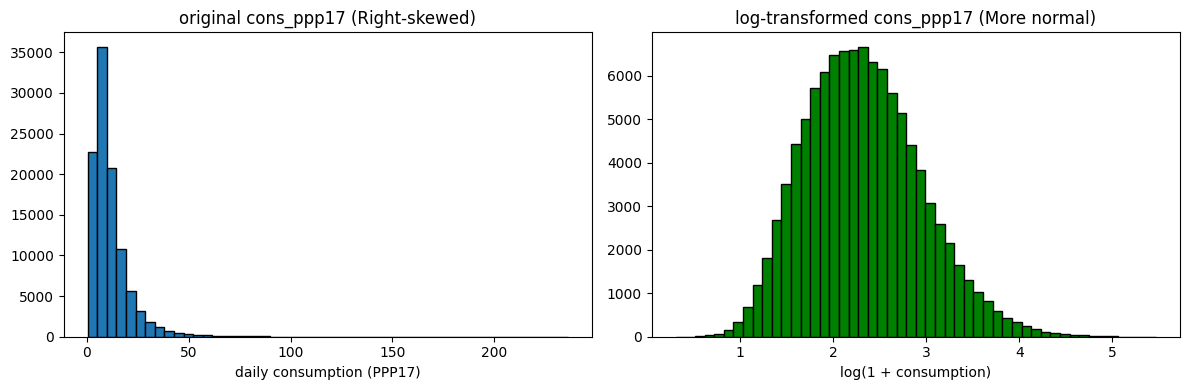

original y - skewness: 3.72
log y - skewness: 0.40


In [18]:
# for the y dataset only!!!! (target)
# I use log transform because I want to make the skewed data as normal as possible
# for instance, I may spend 5, 10, 50, 5000 per day, so 5000 is an extreme outlier
# that way I decrease the spreading of the data in the axis

# visualize target distribution before transformation
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# pre log transforming
axes[0].hist(y, bins=50, edgecolor='black')
axes[0].set_title('original cons_ppp17 (Right-skewed)')
axes[0].set_xlabel('daily consumption (PPP17)')

# post log transform
y_log = np.log1p(y)  # log1p = log(1 + x), handles 0s safely
axes[1].hist(y_log, bins=50, edgecolor='black', color='green')
axes[1].set_title('log-transformed cons_ppp17 (More normal)')
axes[1].set_xlabel('log(1 + consumption)')

plt.tight_layout()
plt.show()

print(f"original y - skewness: {y.skew():.2f}")
print(f"log y - skewness: {y_log.skew():.2f}")

The left (blue) chart, shows that:
- most households belong to low values 0-25
- the tail is stretching to 200+
- skewness is 3.72 (big right skew)

<br>

The right (green) chart, shows that:
- there's a bell shaped chart
- skewness is 0.4, which is normal
- no extreme deviations or boundaries

# Split Data

In [19]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    x,          # features
    y_log,      # log-transformed target
    test_size=0.2, # could be easily 90-10 since we have many data
    random_state=42  # for reproducibility
)

print(f"training set:   {x_train.shape[0]} samples")
print(f"validation set: {x_val.shape[0]} samples")

training set:   83387 samples
validation set: 20847 samples


# Data Standarization

In [21]:
from sklearn.preprocessing import StandardScaler

# planning to use NN too, so I standarize my data
# if tree-based methods will be used, I will only normalize them

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

x_test_scaled = scaler.transform(x_test)

print(f"scaled x_train shape: {x_train_scaled.shape}")
print(f"scaled x_val shape: {x_val_scaled.shape}")
print(f"scaled x_test shape: {x_test_scaled.shape}")

scaled x_train shape: (83387, 84)
scaled x_val shape: (20847, 84)
scaled x_test shape: (103023, 84)


# Summary

- 1.1 - Imported libraries
- 1.2 - Loaded data (train_features, test_features, train_gt)
- 1.3 - Merged features with target
- 1.4 - Checked missing values
- 1.5 - Handled missing values:
  - sector1d: filled with "Not employed"
  - dweltyp: filled with mode
  - utl_exp_ppp17: filled with median
  - others: filled with mode
- 1.6 - Identified column types (binary, multiclass, numerical)
- 1.7 - Encoded binary columns (y/n → 1/0)
- 1.8 - Encoded multiclass columns (with LabelEncoder)
- 1.9 - Created x, y, x_test
- 1.10 - Log transformation of the target set (y_log)
- 1.11 - Train/validation split (80/20)
- 1.12 - Data Standarization

<br>
<br>

1. `x_train` (83387, 84)
2. `x_val` (20847, 84)
3. `y_train` (83387)
4. `y_val` (20847)

<br>

5. `x_train_scaled` (83387, 84)
6. `x_val_scaled` (20847, 84)

<br>

7. `x_test` (103023, 84)
8. `x_test_scaled` (103023, 84)



# ------------------------------------------------------------------



# Target distribution by Survey

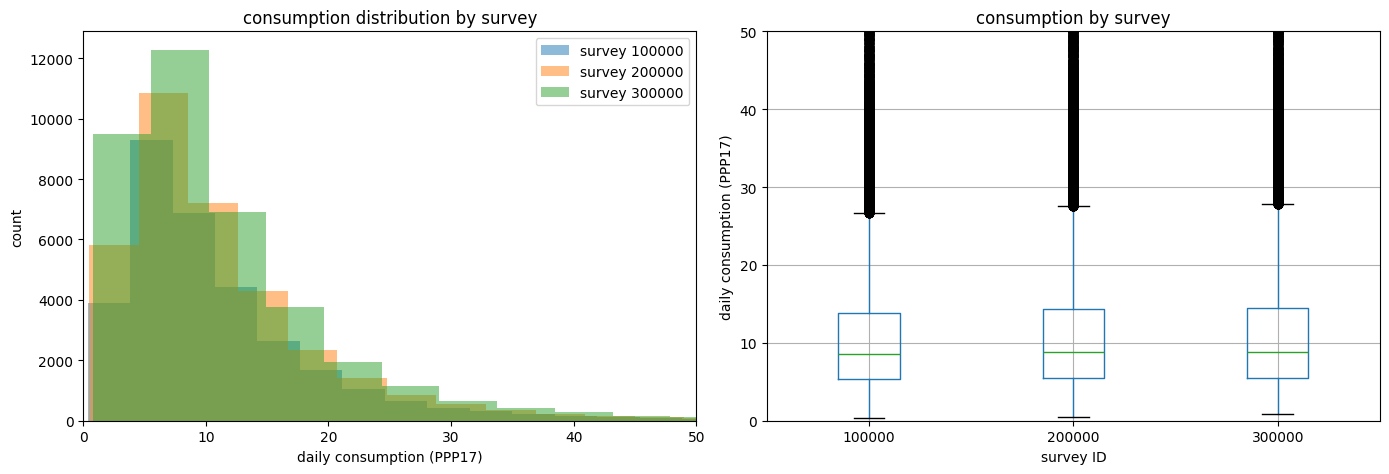

statistics by survey:
             count   mean    std   min   25%   50%    75%     max
survey_id                                                        
100000     32188.0  11.29   9.90  0.36  5.31  8.57  13.85  173.54
200000     34584.0  11.65  10.03  0.50  5.51  8.88  14.31  202.69
300000     37462.0  11.70  10.15  0.82  5.49  8.84  14.41  236.12


In [24]:
# merging original y with survey_id for analysis
train_analysis = train[['survey_id', 'cons_ppp17']].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# left chart is about the distribution by survey
for survey in sorted(train_analysis['survey_id'].unique()):
    subset = train_analysis[train_analysis['survey_id'] == survey]['cons_ppp17']
    axes[0].hist(subset, bins=50, alpha=0.5, label=f'survey {survey}')

axes[0].set_title('consumption distribution by survey')
axes[0].set_xlabel('daily consumption (PPP17)')
axes[0].set_ylabel('count')
axes[0].legend()
axes[0].set_xlim(0, 50)  # Zoom in to see differences

# right chart is about the box plot by survey
train_analysis.boxplot(column='cons_ppp17', by='survey_id', ax=axes[1])
axes[1].set_title('consumption by survey')
axes[1].set_xlabel('survey ID')
axes[1].set_ylabel('daily consumption (PPP17)')
axes[1].set_ylim(0, 50)
plt.suptitle('')

plt.tight_layout()
plt.show()

print("statistics by survey:")
print(train_analysis.groupby('survey_id')['cons_ppp17'].describe().round(2))

So tiny diffs that no modifications needed at all.

# Correlation analysis for Target values